RUN SBI-SGM in alpha, new bounds, new SGM, only three parameters needed

parameters order is  :tauG,speed,alpha (In second)


In [49]:
run_python_script = False

False

## Import some pkgs

In [50]:
import sys
sys.path.append("../mypkg")

import scipy
import itertools

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict

In [52]:
# SBI and torch
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import analysis
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as sutils

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [53]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
# 
from constants import RES_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch

## Some fns

In [54]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

<function __main__.<lambda>(x)>

In [55]:
# transfer vec to a sym mat
def vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

### Some parameters

In [57]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values;

# PSD
#ind_psd_xr = xr.open_dataarray(DATA_ROOT/'individual_psd_reordered_matlab.nc')
#ind_psd = ind_psd_xr.values
#fvec = ind_psd_xr["frequencies"].values;

In [59]:
from scipy.io import loadmat
# The array is ordered as in ‘alpha’, ‘beta_l’, ‘delta’, ‘theta’
diag_ws = loadmat(DATA_ROOT/"diagonal_UFU.mat")["prjctFC_diag"];
diag_ws = np.abs(diag_ws).mean(axis=(1, 2));

In [60]:
_paras = edict()
_paras.delta = [2, 3.5]
_paras.theta = [4, 7]
_paras.alpha = [8, 12]
_paras.beta_l = [13, 20]

In [62]:
paras = edict()

paras.fc_type = "alpha" #stick to coh
paras.freqrange =  np.linspace(_paras[paras.fc_type][0], _paras[paras.fc_type][1], 5)
paras.diag_ws = diag_ws
print(paras.freqrange)
paras.fs = 600
paras.num_nodes = 86 # Number of cortical (68) + subcortical nodes
paras.par_low = np.asarray([0.005, 5, 0.1])
paras.par_high = np.asarray([0.03, 20, 1])
paras.names = ["TauC", "Speed", "alpha"]
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.prior_sd = 10 # noise sd added on the FC
paras.add_v = 0.05

paras.SBI_paras = edict()
paras.SBI_paras.num_prior_sps = int(1e3)
paras.SBI_paras.density_model = "nsf" # density estimator, mdn,maf,nsf  
paras.SBI_paras.noise_sd = 0.2 # 1.2
paras.SBI_paras.num_round = 3 # 5
print(paras.diag_ws);

[ 8.  9. 10. 11. 12.]
[28.34730666  2.04960239  1.70749507  1.22529579  2.07701591  0.53111972
  0.6218343   0.60427364  0.42565082  0.24645076  0.31900365  0.25322547
  0.23310096  0.23638545  0.29637963  0.29173875  0.32172899  0.34877173
  0.37271771  0.3407041   0.42165469  0.44977377  0.49267775  0.53535327
  0.45689171  0.5307152   0.49010218  0.52487552  0.48627499  0.47017923
  0.57866959  0.51133174  0.49745823  0.56322006  0.55008061  0.58736851
  0.5917356   0.57619634  0.57585997  0.64097135  0.63919469  0.67089503
  0.70194127  0.69713099  0.72477668  0.75575609  0.72799299  0.74255208
  0.74701997  0.74549816  0.74341354  0.75704742  0.72661308  0.7535987
  0.77213942  0.77174635  0.76942024  0.78661123  0.78909111  0.7723603
  0.76788512  0.76919267  0.79200622  0.78210296  0.84090921  0.84930545
  0.85326197  0.85928982]


In [12]:
# fn for reparametering
# theta [0, 1] --logistic--> \hat{theta} [-infy, infy], normal prior
_map_fn_torch = partial(logistic_torch, k=0.1)
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=0.1))

functools.partial(<function theta_raw_2out at 0x7f2c417e7670>, map_fn=functools.partial(<function logistic_np at 0x7f2c417e75e0>, k=0.1))

### Load the data

In [63]:

def _add_v2con(cur_ind_conn):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.max(cur_ind_conn)*paras.add_v # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], np.diag(cur_ind_conn[:34, 34:68]) + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], np.diag(cur_ind_conn[34:68, :34]) + add_v)
    np.fill_diagonal(cur_ind_conn[68:77, 77:], np.diag(cur_ind_conn[68:77, 77:]) + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], np.diag(cur_ind_conn[77:, 68:77]) + add_v)
    return cur_ind_conn

if paras.add_v != 0:
    print(f"Add {paras.add_v} on diag")
    ind_conn_adds = [_add_v2con(ind_conn[:, :, ix]) for ix in range(36)]
    ind_conn = np.transpose(np.array(ind_conn_adds), (1, 2, 0))

Add 0.05 on diag


In [64]:
# Load true MEG FC time series:
dataPath = DATA_ROOT/f'./MEG_FC_{paras.fc_type}_DK_networks_coh.mat'
data = loadmat(dataPath);
true_FC = data[f"MEG_{paras.fc_type}_FC_networks_coh"]
true_FC.shape

(68, 68, 36)

## SBI

### Prior

In [65]:
prior = MultivariateNormal(loc=torch.zeros(3), covariance_matrix=torch.eye(3)*(paras.prior_sd**2))

MultivariateNormal(loc: torch.Size([3]), covariance_matrix: torch.Size([3, 3]))

In [66]:
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT) # grabs distance matrix
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.connectome =  ind_conn[:, :, 0] # re-assign connectome to individual connectome
brain.bi_symmetric_c()
brain.reduce_extreme_dir()
    

In [19]:
# If we want to use SBI for other model, 
# this function should be customized on your own.
def simulator(raw_params, brain, noise_sd, prior_bds, freqrange, diag_ws):
    params = []
    for raw_param, prior_bd in zip(raw_params, prior_bds):
        param =  _map_fn_torch(raw_param)*(prior_bd[1]-prior_bd[0]) + prior_bd[0]
        params.append(param)
    params = torch.tensor(params)
    
    params_dict = dict()
    params_dict["tauC"] =  params[0].item()
    params_dict["speed"] =  params[1].item()
    params_dict["alpha"] =  params[2].item()
    modelFC = build_fc_freq_m(brain , params_dict, freqrange, diag_ws)
    modelFC_abs = np.abs(modelFC[:68, :68])
    res = _minmax_vec(modelFC_abs[np.triu_indices(68, k = 1)])
    noise =  np.random.randn(*res.shape)*noise_sd
    return (res+ noise).flatten()
    

In [67]:
cur_ind_idx = 0 # run sbi on subject 0

# to get the SC and distance matrix for SGM
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT) # grabs distance matrix
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.connectome =  ind_conn[:, :, cur_ind_idx] # re-assign connectome to individual connectome
brain.bi_symmetric_c()
brain.reduce_extreme_dir()
    
simulator_sp = partial(simulator, 
                       brain=brain, 
                       noise_sd=paras.SBI_paras.noise_sd, 
                       prior_bds=paras.prior_bds, 
                       freqrange=paras.freqrange, 
                       diag_ws=paras.diag_ws)
## Prepare simulator and prior for usage in sbi.
# refer to https://www.mackelab.org/sbi/reference/#sbi.utils.user_input_checks.prepare_for_sbi
simulator_wrapper, prior = prepare_for_sbi(simulator_sp, prior)
## The algorithm to estimate the posterior, I prefer this one.
# typically, no need to change
# density_estimator: nsf, maf, mdn. 
# you may change it if the default one do not have good performance
inference = SNPE(prior=prior, density_estimator=paras.SBI_paras.density_model)
    
#the observed data to feed the SBI
cur_obs_FC = np.abs(true_FC[:, :, cur_ind_idx])
curX = torch.Tensor(_minmax_vec(cur_obs_FC[np.triu_indices(68, k = 1)]));

In [68]:
### To fit SBI with single runs 
# to simulate the training samples, very time-consuming
theta, x = simulate_for_sbi(simulator_wrapper, proposal=prior,
                            num_simulations=int(paras.SBI_paras.num_prior_sps),
                            num_workers=20)
# note that proposal is not necessarily the same to the prior
density_estimator = inference.append_simulations(
                     theta, x, proposal=prior,
                     ).train()
posterior = inference.build_posterior(density_estimator)


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 23 epochs.

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

In [69]:
# sample the posterior 
post_sps_raw = posterior.sample((1000, ),x=curX);
# transform back to original SGM 
post_sps = _theta_raw_2out(post_sps_raw.numpy(), paras.prior_bds);

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

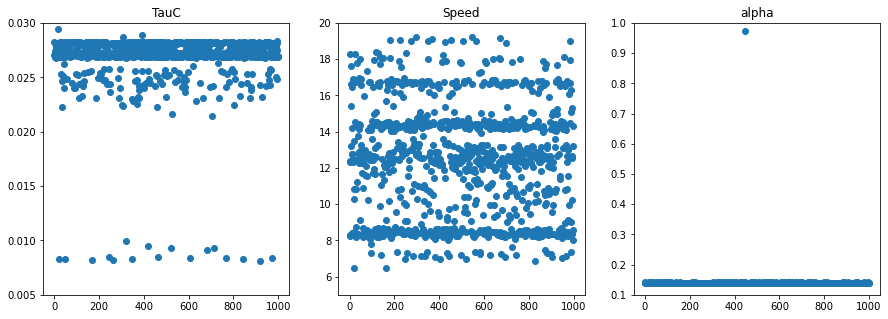

In [71]:
plt.figure(figsize=[15, 5])
for ix in range(3):
    plt.subplot(1, 3, ix+1)
    plt.plot(post_sps[:, ix], "o")
    plt.title(paras.names[ix])
    plt.ylim(paras.prior_bds[ix])

In [ ]:
### To fit SBI with mutliple runs, in my experience, num_round=3 is a good number. 
# for each run, you let the last trained posterior as the current proposal
proposal = prior 
for ix in range(paras.SBI_paras.num_round):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal,
                                num_simulations=int(paras.SBI_paras.num_prior_sps),
                                num_workers=20)
    density_estimator = inference.append_simulations(
                            theta, x, proposal=proposal
                            ).train()
    posterior = inference.build_posterior(density_estimator)
        
        
    #update proposal 
    proposal = posterior.set_default_x(curX)